# Análisis de redes de contratación

### Heriberto Felizzola Jimenez

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite as bp
from copy import deepcopy

In [41]:
!pip show networkx

Name: networkx
Version: 2.4
Summary: Python package for creating and manipulating graphs and networks
Home-page: http://networkx.github.io/
Author: Aric Hagberg
Author-email: hagberg@lanl.gov
License: BSD
Location: /Users/hfelizzola/opt/anaconda3/lib/python3.7/site-packages
Requires: decorator
Required-by: scikit-image


## Cargue de datos

In [3]:
contratos = pd.read_csv('SECOP_IPS_LIMPIA.tsv.gz', sep = ';', 
                        usecols=["año_firma",
                                  "tipo_contrato",
                                  "nombre_entidad",
                                  "nit_entidad",
                                  "tipo_id_contratista",
                                  "id_contratista_mod",
                                  "valor_inicial",
                                  "valor_adiciones",
                                  "valor_total"])
contratos.head()

,año_firma,nombre_entidad,nit_entidad,tipo_contrato,tipo_id_contratista,valor_inicial,valor_adiciones,valor_total,id_contratista_mod
0,2016,ANTIOQUIA - HOSPITAL GENERAL DE MEDELLÍN,890904646,Suministro,Nit de Persona Jurídica,550502,0,550502,8.605274e+09
1,2018,ANTIOQUIA - E.S.E. HOSPITAL SANTA MARGARITA - ...,890980949,Prestación de Servicios,Cédula de Ciudadanía,8549025,3945705,12494730,4.268955e+07
2,2016,CALDAS - E.S.E. HOSPITAL SAN VICENTE DE PAÚL -...,800191101,Prestación de Servicios,Cédula de Ciudadanía,10000000,0,10000000,1.060649e+09
3,2018,CÓRDOBA - E.S.E. HOSPITAL SAN RAFAEL DE CHINÚ,800193912,Prestación de Servicios,Cédula de Ciudadanía,6028000,0,6028000,1.066175e+09
4,2016,ANTIOQUIA - E.S.E. HOSPITAL LA MARÍA - MEDELLÍN,890905177,Suministro,Nit de Persona Jurídica,2600700,0,2600700,9.001018e+08


In [4]:
contratos.shape

(833505, 9)

In [5]:
contratos = contratos.loc[contratos['tipo_contrato'] != "Prestación de Servicios"]

In [6]:
contratos.shape

(246810, 9)

## Análisis de la red bipartita

Primero se construye un data frame con las conexiones entre entidades y contratistas, con sus respectivos numeros de contratos.

### Construcción de la red

In [7]:
data_red = contratos.groupby(['nit_entidad','id_contratista_mod']).size().sort_values(ascending = False).reset_index()
data_red.columns = (['Entidad','Contratista','Num_Contratos'])
data_red.head()

,Entidad,Contratista,Num_Contratos
0,890904646,8.909851e+09,1948
1,890905177,8.110225e+08,1470
2,890904646,8.605274e+09,1435
3,890904646,9.000479e+09,1372
4,890980066,8.110329e+08,1264


In [8]:
data_red.shape

(46196, 3)

In [9]:
data_red.describe()

,Entidad,Contratista,Num_Contratos
count,4.619600e+04,4.619600e+04,46196.000000
mean,8.661050e+08,5.450527e+21,5.341436
std,3.875577e+07,6.767377e+23,34.351923
min,8.000068e+08,0.000000e+00,1.000000
25%,8.220066e+08,7.046925e+07,1.000000
50%,8.909052e+08,8.600249e+08,1.000000
75%,8.918004e+08,1.092354e+09,3.000000
max,9.009710e+08,8.600051e+25,1948.000000


Se crea una red bipartita

In [10]:
B = nx.Graph()
B.add_nodes_from(list(np.unique(data_red.Entidad)), bipartite=0)
B.add_nodes_from(list(np.unique(data_red.Contratista)), bipartite=1)

Se construyen y agregan los arcos con las tuplas *(Entidad,Contratista)*

In [11]:
arcos = list()
for i in range(data_red.shape[0]):
    arcos.append((data_red.Entidad[i],data_red.Contratista[i]))

In [12]:
B.add_edges_from(arcos)

### Explorar y ajustar la red

In [13]:
print(nx.info(B))

Name: 
Type: Graph
Number of nodes: 31677
Number of edges: 46194
Average degree:   2.9166


La red tiene un total de 31677 nodos, entre constratistas y entidades, con un total de 46194 arcos, que representan relaciones contractutales, las cuales solo excluyen los *contratos de prestación de servicios*. Esto quiere decir que esta red no es conexa.

In [14]:
def print_graph_stats(B):
    print("Nodos", "Arcos", "Componentes del Subgrafo")
    print(B.number_of_nodes(), B.number_of_edges(), nx.number_connected_components(B))

print_graph_stats(B)

Nodos Arcos Componentes del Subgrafo
31677 46194 25


Se tienen un total de:
 - 708 Entidades
 - 31137 Contratistas

In [17]:
B_entidades = [x for x, y in B.nodes(data=True) if y['bipartite'] == 0] 
# https://stackoverflow.com/questions/31922917/select-network-nodes-with-a-given-attribute-value
B_contratistas = [x for x, y in B.nodes(data=True) if y['bipartite'] == 1]
print(len(B_entidades), len(B_contratistas))

599 31078


Hay un componente grande de 31660 nodos, y otros componentes pequeños de entre 2 y 33 nodos. Tendriamos que revisar en detalle cuales son los nodos de estos componentes.

In [51]:
subs = list(nx.connected_components(B))

In [71]:
comp_nodos = [len(subs[i]) for i in range(len(subs))]
componentes = pd.DataFrame({"Componente": [i for i in range(len(comp_nodos))],
                            "Numero de Nodos": comp_nodos})
componentes.sort_values("Numero de Nodos", ascending=False)

,Componente,Numero de Nodos
0,0,31501
2,2,33
14,14,15
19,19,14
12,12,14
1,1,13
21,21,11
5,5,10
15,15,7
8,8,6


Se tienen 176 nodos que quedarian en los componentes pequeños.

In [72]:
nod_comp_peq = list()
for i in range(len(subs)):
    if len(subs[i]) < 100:
        nod_comp_peq += list(subs[i])
len(nod_comp_peq)

176

A continuación se presenta una tabla de frecuencia con los grados de los nodos entidad y contratistas:

In [30]:
#G2_user_nodes = [x for x, y in G2.nodes(data=True) if y['bipartite'] == 0] # use to filter
#G2_project_nodes = [x for x, y in G2.nodes(data=True) if y['bipartite'] == 1] # use to filter
node_dict = dict(nx.degree(B)) # node degress
node_df = pd.DataFrame(list(node_dict.items()), columns=['Nodo', 'Grado']) 
# https://stackoverflow.com/questions/18837262/convert-python-dict-into-a-dataframe
entidades_df, contratistas_df = node_df[node_df.Nodo.isin(B_entidades)], node_df[node_df.Nodo.isin(B_contratistas)]

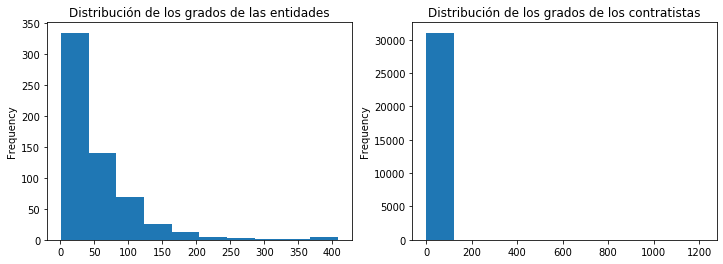

In [77]:
plt.figure(figsize=(12,4))
plt.subplot(121)
entidades_df.Grado.plot.hist()
plt.title("Distribución de los grados de las entidades")
plt.subplot(122)
contratistas_df.Grado.plot.hist()
plt.title("Distribución de los grados de los contratistas")
plt.savefig(fname="Distribución de los grados")
plt.show()

Tenemos 12 entidades y 26649 contratistas con grado 1:

- ¿Los eliminamos? 
- ¿Son irelevantes en el análisis?

Para facilitar el analisis se quitan los nodos con grado menor a 4.

In [78]:
corte = 4
print('Entidades: '+ str(np.sum(entidades_df.Grado <= corte)))
print('Contratistas: '+ str(np.sum(contratistas_df.Grado <= corte)))

Entidades: 41
Contratistas: 29951


In [79]:
nodos_elim = entidades_df[entidades_df.Grado <= corte].Nodo
nodos_elim = nodos_elim.append(contratistas_df[contratistas_df.Grado <= corte].Nodo)

In [80]:
B2 = deepcopy(B)
B2.remove_nodes_from(nodos_elim)
print_graph_stats(B2)

Nodos Arcos Componentes del Subgrafo
1685 11170 25


Tenemos 23 componentes con grado 1 nodo cuales se retiran del análisis. 

In [82]:
B2_subs = list(nx.connected_components(B2))
print([len(sub) for sub in B2_subs])

[1661, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [83]:
nodo_desc = list()
for i in range(len(B2_subs)):
    if len(B2_subs[i]) <= 1:
        nodo_desc = nodo_desc + list(B2_subs[i])

B3 = deepcopy(B2) 
B3.remove_nodes_from(nodo_desc)

Al remover los componentes desconectados, se tiene un solo componente con 2881 nodos y 15079 arcos.

In [84]:
print_graph_stats(B3)

Nodos Arcos Componentes del Subgrafo
1661 11169 1


### Dibujar la red

![Red Bipartita](red.png)

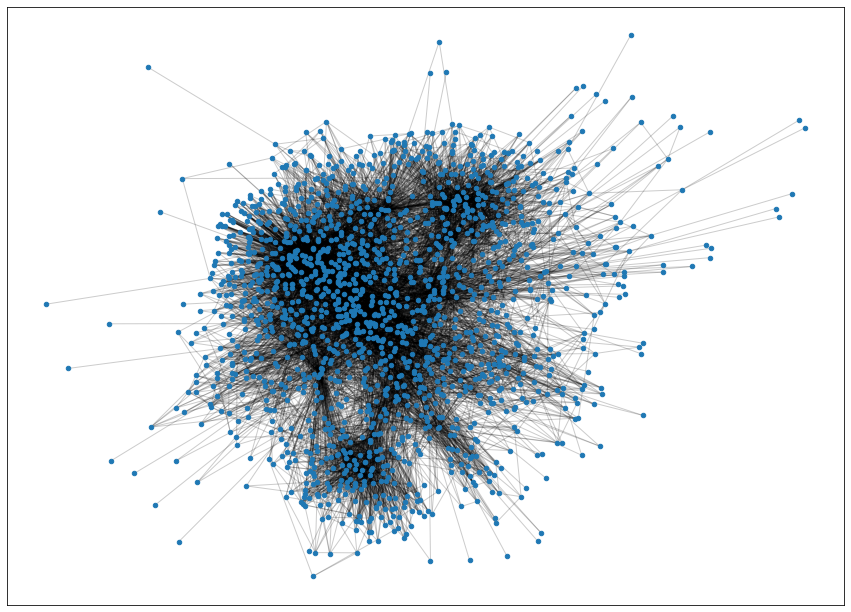

In [85]:
plt.figure(figsize=(15, 11))
pos = nx.spring_layout(B3)
nx.draw_networkx_nodes(B3, pos, node_size=20)
nx.draw_networkx_edges(B3, pos, alpha=0.2, col = "lighgray")
plt.show()

In [86]:
nx.write_gexf(B3, 'B3_Contratos.gexf')

### Análisis de medidas de centralidad

In [87]:
# Función para generar las medidas de centralidad: degree, eigenvector, betweenness y closeness
def centrality_df(g, function):
    if function in ['degree', 'eigenvector', 'betweenness', 'closeness']:
        if function == 'degree':
            node_measure_dict = dict(nx.degree_centrality(g)) 
        elif function == 'eigenvector':    
            node_measure_dict = dict(nx.eigenvector_centrality(g)) 
        elif function == 'betweenness':    
            node_measure_dict = dict(nx.betweenness_centrality(g))
        else:        
            node_measure_dict = dict(nx.closeness_centrality(g)) 
    
        node_measure_df = pd.DataFrame(list(node_measure_dict.items()), columns=['node', 'measure']) # https://stackoverflow.com/questions/18837262/convert-python-dict-into-a-dataframe
        #node_name_dict = dict(nx.get_node_attributes(g.subgraph(tipo_nodo), 'name'))
        #node_name_df = pd.DataFrame(list(node_name_dict.items()), columns=['node', 'name'])
        #node_df = pd.merge(node_measure_df, node_name_df, how='left', on='node').set_index('name').drop('node', axis=1)
        return node_measure_df.sort_values('measure', ascending=False)
    else: 
        print('Error: please select one of the following functions: degree, eigenvector, betweenness, closeness')

### Analisis del grado de los nodos

Para este análisis se tienen 642 entidades y 1016 contratistas.

In [88]:
# Extraer entidades y contratistas
B3_entidades = [x for x, y in B3.nodes(data=True) if y['bipartite'] == 0] 
B3_contratistas = [x for x, y in B3.nodes(data=True) if y['bipartite'] == 1]
print(len(B3_entidades), len(B3_contratistas))

535 1126


In [100]:
degree_measures = centrality_df(g = B3, function = 'degree')
print(degree_measures.measure.describe())

count    1661.000000
mean        0.008102
std         0.011447
min         0.000602
25%         0.003012
50%         0.004819
75%         0.008434
max         0.167470
Name: measure, dtype: float64


(array([1.522e+03, 8.900e+01, 2.500e+01, 1.300e+01, 6.000e+00, 2.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([0.00060241, 0.01728916, 0.0339759 , 0.05066265, 0.0673494 ,
        0.08403614, 0.10072289, 0.11740964, 0.13409639, 0.15078313,
        0.16746988]),
 <a list of 10 Patch objects>)

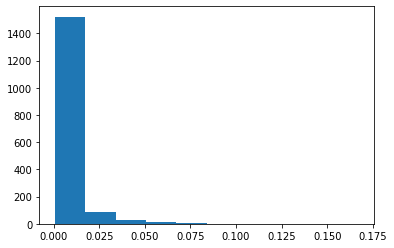

In [103]:
plt.hist(x = degree_measures.measure)

### Analisis de la intermediación del nodo

In [98]:
betweenness_measures = centrality_df(g = B3, function = 'betweenness')
print(betweenness_measures.measure.describe())

count    1661.000000
mean        0.001460
std         0.004748
min         0.000000
25%         0.000081
50%         0.000260
75%         0.000996
max         0.088503
Name: measure, dtype: float64


### Analisis de la cercania

In [104]:
closeness_measures = centrality_df(g = B3, function = 'closeness')
print(closeness_measures.measure.describe())

count    1661.000000
mean        0.295972
std         0.032558
min         0.198020
25%         0.272220
50%         0.296534
75%         0.319477
max         0.429273
Name: measure, dtype: float64


### Eigen Vector Centrality

In [105]:
eigenvenctor_measures = centrality_df(g = B3, function = 'eigenvector')
print(eigenvenctor_measures.measure.describe())

count    1661.000000
mean        0.013308
std         0.020620
min         0.000006
25%         0.002176
50%         0.005823
75%         0.016477
max         0.282433
Name: measure, dtype: float64


### Graficas

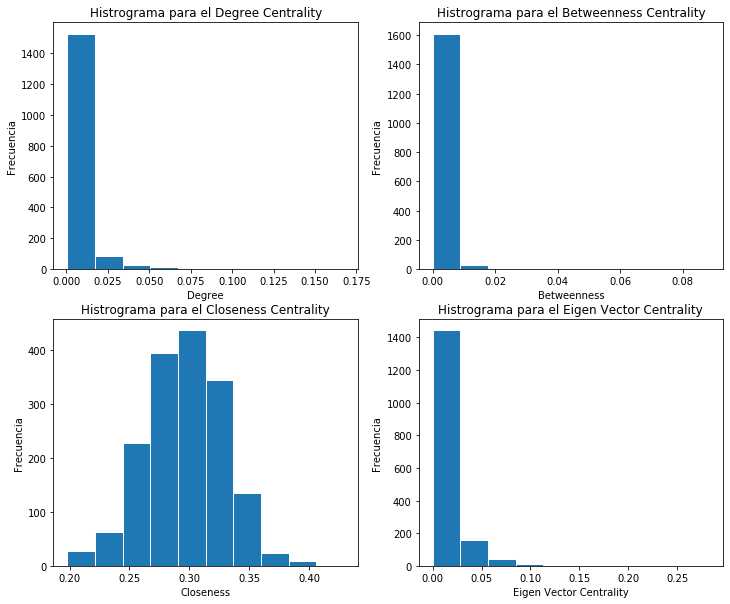

In [116]:
plt.figure(figsize=(12,10))

plt.subplot(221)
plt.hist(x = degree_measures.measure, edgecolor="w")
plt.title("Histrograma para el Degree Centrality")
plt.xlabel("Degree")
plt.ylabel("Frecuencia")

plt.subplot(222)
plt.hist(x = betweenness_measures.measure, edgecolor="w")
plt.title("Histrograma para el Betweenness Centrality")
plt.xlabel("Betweenness")
plt.ylabel("Frecuencia")

plt.subplot(223)
plt.hist(x = closeness_measures.measure, edgecolor="w")
plt.title("Histrograma para el Closeness Centrality")
plt.xlabel("Closeness")
plt.ylabel("Frecuencia")

plt.subplot(224)
plt.hist(x = eigenvenctor_measures.measure, edgecolor="w")
plt.title("Histrograma para el Eigen Vector Centrality")
plt.xlabel("Eigen Vector Centrality")
plt.ylabel("Frecuencia")

plt.savefig("Distribucion_Medidas_Centralidad")

plt.show()